In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from ThreeWToolkit.dataset import ParquetDataset, DatasetConfig
from ThreeWToolkit.core.base_dataset import EventPrefixEnum
from ThreeWToolkit.utils.data_utils import default_data_cleanup, default_data_normalization, default_data_processing

## Load raw dataset

In [2]:
dataset_path = Path("./dataset")
ds_config = DatasetConfig(path=dataset_path, split=None, file_type="parquet") # load all files, target defaults to 'class'
ds = ParquetDataset(ds_config, download=False) # download

In [3]:
averages = []
counts   = []
for event in ds:
    signal = event['signal']
    averages.append(signal.mean())
    counts.append(signal.count())

# Check missing data

In [4]:
total = sum(counts)
total

ABER-CKGL         8491513
ABER-CKP         12326458
ESTADO-DHSV      13865397
ESTADO-M1        17773205
ESTADO-M2        17688282
ESTADO-PXO       18176203
ESTADO-SDV-GL    17105271
ESTADO-SDV-P     24316107
ESTADO-W1        18938036
ESTADO-W2        18293462
ESTADO-XO        18538730
P-ANULAR         25460515
P-JUS-BS                0
P-JUS-CKGL       31896234
P-JUS-CKP        22115960
P-MON-CKGL         308726
P-MON-CKP        69507467
P-MON-SDV-P             0
P-PDG            68671102
PT-P                    0
P-TPT            71205535
QBS                     0
QGL              24565960
T-JUS-CKP        60554418
T-MON-CKP        23617605
T-PDG            20811272
T-TPT            66325278
state            72558918
dtype: int64

In [5]:
missing_columns = total[total == 0].index
missing_columns

Index(['P-JUS-BS', 'P-MON-SDV-P', 'PT-P', 'QBS'], dtype='object')

No single event in dataset 2.0.0 contains any of these tags.

P-MON-CKGL is also suspect. We also have frozen sensors...

# What about averages?

Distrubution of averages

In [6]:
signals = counts[0].index
distribution = {s: [] for s in signals}

for s in signals:
    for a, c in zip(averages, counts):
        if c[s] != 0:
            distribution[s].append(a[s])

In [7]:
def plot_boxes(distribution):
    N_ROWS = int(np.ceil(np.sqrt(len(distribution))))
    N_COLS = int(np.ceil(len(distribution) / N_ROWS))
    
    fig, ax = plt.subplots(N_ROWS, N_COLS, figsize=(16, 9), tight_layout=True)
    
    for i, (k, v) in enumerate(distribution.items()):
        ax[i // N_COLS, i % N_COLS].boxplot(v)
        ax[i // N_COLS, i % N_COLS].set_title(k)
        ax[i // N_COLS, i % N_COLS].grid()

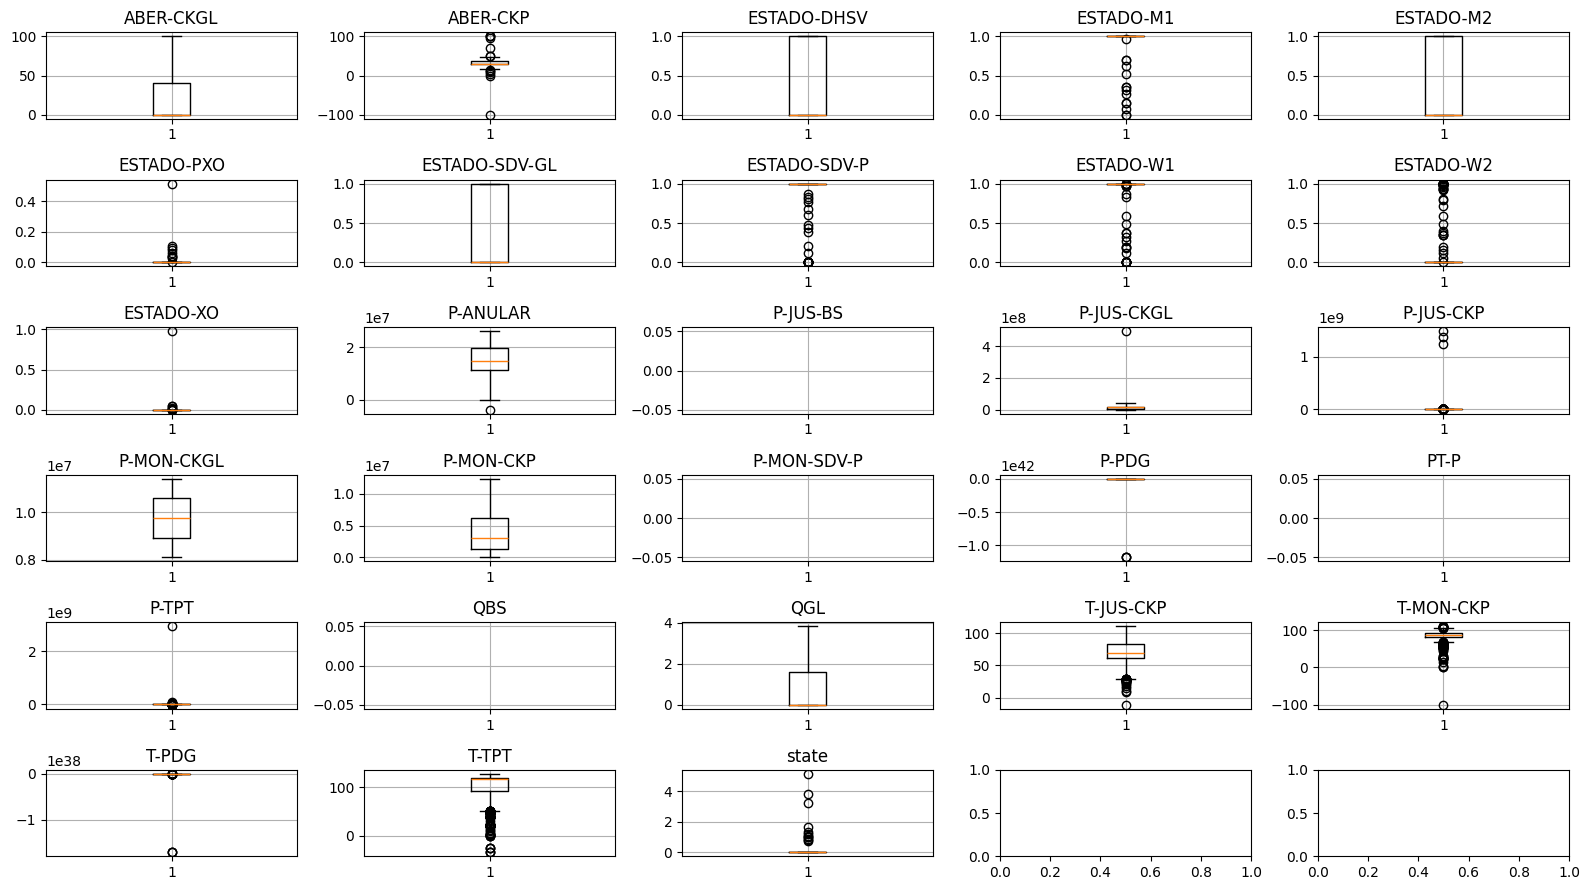

In [8]:
plot_boxes(distribution)

Affected Tags:

    ABER-CKP: Negative values
    P-JUS-CKGL: Readings capping scale
    P-JUS-CKP:  Readings capping scale
    P-PDG: same
    P-TPT: same
    T-MON-CKP: large negative values
    T-PDG: capping scale

Possible solution:

    Removing affected files (easy, worse)
    Ignoring apparently wrong data (harder, will require metadata)

## Data cleaning

In [9]:
cleaned = ds.transform({"signal": default_data_cleanup})

Default data cleaning applies the following processes:

    Removal of unused tags
    Removal of frozen data
    Removel of out-of-range values

In [10]:
averages = []
counts   = []
for event in cleaned:
    signal = event['signal']
    averages.append(signal.mean())
    counts.append(signal.count())

In [11]:
total = sum(counts)
total

ABER-CKGL         8491513
ABER-CKP         12164586
ESTADO-DHSV      13865397
ESTADO-M1        17773205
ESTADO-M2        17688282
ESTADO-PXO       18176203
ESTADO-SDV-GL    17105271
ESTADO-SDV-P     24316107
ESTADO-W1        18938036
ESTADO-W2        18293462
ESTADO-XO        18538730
P-ANULAR         24933101
P-JUS-CKGL       31185273
P-JUS-CKP        20609019
P-MON-CKP        69507467
P-PDG            50783893
P-TPT            69338750
QGL              24565960
T-JUS-CKP        60525765
T-MON-CKP        23456067
T-PDG             7591233
T-TPT            63819853
dtype: int64

Tags that are mostly missing are removed.
Reading errors are sensibly removed.

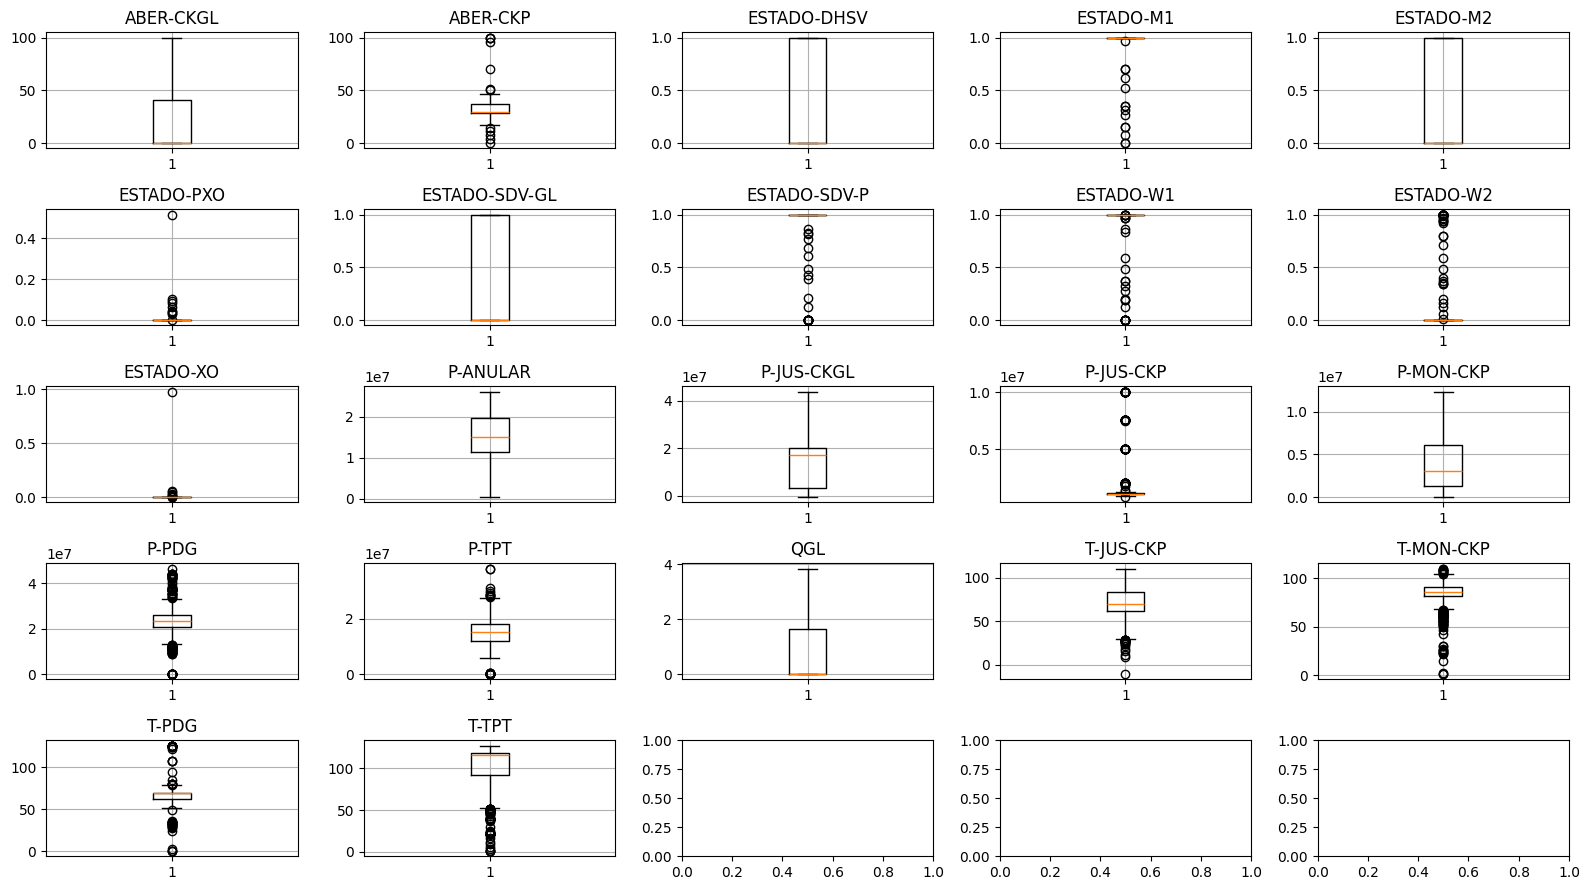

In [12]:
signals = counts[0].index
distribution = {s: [] for s in signals}

for s in signals:
    for a, c in zip(averages, counts):
        if c[s] != 0:
            distribution[s].append(a[s])
plot_boxes(distribution)

It is now possible to compute, for instance, global averages/deviations:

In [13]:
global_avg = sum(a.fillna(0) * c / total for a, c in zip(averages, counts))
global_avg

ABER-CKGL        1.931843e+01
ABER-CKP         4.239023e+01
ESTADO-DHSV      5.703575e-01
ESTADO-M1        8.532889e-01
ESTADO-M2        3.172376e-01
ESTADO-PXO       8.822910e-03
ESTADO-SDV-GL    5.448040e-01
ESTADO-SDV-P     9.110019e-01
ESTADO-W1        7.026502e-01
ESTADO-W2        2.407879e-01
ESTADO-XO        3.095789e-03
P-ANULAR         1.543509e+07
P-JUS-CKGL       1.633026e+07
P-JUS-CKP        1.848287e+06
P-MON-CKP        3.373246e+06
P-PDG            2.178213e+07
P-TPT            1.397929e+07
QGL              1.304284e+00
T-JUS-CKP        6.926409e+01
T-MON-CKP        7.168256e+01
T-PDG            7.412067e+01
T-TPT            9.690458e+01
dtype: float64

and for the deviations:

In [14]:
counts     = []
deviations = []
for event in cleaned:
    signal = event['signal']
    deviations.append((signal - global_avg).pow(2).mean())
    counts.append(signal.count())


In [15]:
global_std = sum(d.fillna(0) * c / total for d, c in zip(deviations, counts)).pow(0.5)
global_std

ABER-CKGL        3.040066e+01
ABER-CKP         2.847642e+01
ESTADO-DHSV      4.950251e-01
ESTADO-M1        3.538177e-01
ESTADO-M2        4.653943e-01
ESTADO-PXO       9.351506e-02
ESTADO-SDV-GL    4.979886e-01
ESTADO-SDV-P     2.847410e-01
ESTADO-W1        4.570918e-01
ESTADO-W2        4.275588e-01
ESTADO-XO        5.555363e-02
P-ANULAR         6.251561e+06
P-JUS-CKGL       1.227916e+07
P-JUS-CKP        2.069025e+06
P-MON-CKP        3.175275e+06
P-PDG            8.057268e+06
P-TPT            5.887995e+06
QGL              1.541538e+00
T-JUS-CKP        1.903404e+01
T-MON-CKP        2.898848e+01
T-PDG            2.331257e+01
T-TPT            3.053168e+01
dtype: float64

We can then apply default_data_normalization to achieve the normalization effect

In [16]:
normalized = cleaned.transform({"signal": default_data_normalization})

In [17]:
averages = []
counts   = []
for event in normalized:
    signal = event['signal']
    averages.append(signal.mean())
    counts.append(signal.count())
total = sum(counts)

global_avg = sum(a.fillna(0) * c / total for a, c in zip(averages, counts))
global_avg

ABER-CKGL       -5.399433e-08
ABER-CKP        -1.689917e-07
ESTADO-DHSV     -2.468450e-08
ESTADO-M1       -8.649546e-08
ESTADO-M2        4.497032e-08
ESTADO-PXO      -1.888944e-09
ESTADO-SDV-GL   -7.264889e-09
ESTADO-SDV-P    -9.786592e-08
ESTADO-W1       -9.045392e-08
ESTADO-W2        8.966150e-08
ESTADO-XO        3.487768e-09
P-ANULAR        -2.581572e-07
P-JUS-CKGL       2.111727e-07
P-JUS-CKP       -1.571528e-07
P-MON-CKP       -2.899771e-08
P-PDG            1.286268e-07
P-TPT            4.007722e-07
QGL             -3.407008e-08
T-JUS-CKP       -2.693583e-08
T-MON-CKP        4.666847e-08
T-PDG            3.946822e-09
T-TPT            1.386824e-07
dtype: float64

In [18]:
counts     = []
deviations = []
for event in normalized:
    signal = event['signal']
    deviations.append((signal - global_avg).pow(2).mean())
    counts.append(signal.count())
total = sum(counts)

global_std = sum(d.fillna(0) * c / total for d, c in zip(deviations, counts)).pow(0.5)
global_std

ABER-CKGL        1.0
ABER-CKP         1.0
ESTADO-DHSV      1.0
ESTADO-M1        1.0
ESTADO-M2        1.0
ESTADO-PXO       1.0
ESTADO-SDV-GL    1.0
ESTADO-SDV-P     1.0
ESTADO-W1        1.0
ESTADO-W2        1.0
ESTADO-XO        1.0
P-ANULAR         1.0
P-JUS-CKGL       1.0
P-JUS-CKP        1.0
P-MON-CKP        1.0
P-PDG            1.0
P-TPT            1.0
QGL              1.0
T-JUS-CKP        1.0
T-MON-CKP        1.0
T-PDG            1.0
T-TPT            1.0
dtype: float64

If we wished to replace NaN values with, for instance, the average (which is now 0), we could apply the following transform:

In [19]:
imputed = normalized.transform({"signal": lambda signal, *args, **kwargs: signal.fillna(0)})

In [20]:
imputed[0]['signal'].head()

,ABER-CKGL,ABER-CKP,ESTADO-DHSV,ESTADO-M1,ESTADO-M2,ESTADO-PXO,ESTADO-SDV-GL,ESTADO-SDV-P,ESTADO-W1,ESTADO-W2,...,P-JUS-CKGL,P-JUS-CKP,P-MON-CKP,P-PDG,P-TPT,QGL,T-JUS-CKP,T-MON-CKP,T-PDG,T-TPT
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-26 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717287,1.002349,0.0,0.778583,0.497141,0.0,0.852250
2018-04-26 00:20:01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717285,1.002358,0.0,0.778582,0.497141,0.0,0.852250
2018-04-26 00:20:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717287,1.002366,0.0,0.778581,0.497140,0.0,0.852250
2018-04-26 00:20:03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717288,1.002375,0.0,0.778580,0.497140,0.0,0.852253
2018-04-26 00:20:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717289,1.002383,0.0,0.778580,0.497139,0.0,0.852253


The application of this complete pipeline is available with the default_data_processing function.

In [21]:
default = ds.transform({"signal": default_data_processing})

In [22]:
default[0]['signal'].head()

,ABER-CKGL,ABER-CKP,ESTADO-DHSV,ESTADO-M1,ESTADO-M2,ESTADO-PXO,ESTADO-SDV-GL,ESTADO-SDV-P,ESTADO-W1,ESTADO-W2,...,P-JUS-CKGL,P-JUS-CKP,P-MON-CKP,P-PDG,P-TPT,QGL,T-JUS-CKP,T-MON-CKP,T-PDG,T-TPT
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-26 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717287,1.002349,0.0,0.778583,0.497141,0.0,0.852250
2018-04-26 00:20:01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717285,1.002358,0.0,0.778582,0.497141,0.0,0.852250
2018-04-26 00:20:02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717287,1.002366,0.0,0.778581,0.497140,0.0,0.852250
2018-04-26 00:20:03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717288,1.002375,0.0,0.778580,0.497140,0.0,0.852253
2018-04-26 00:20:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.307776,-0.569434,0.717289,1.002383,0.0,0.778580,0.497139,0.0,0.852253


In [23]:
averages = []
counts   = []
for event in default:
    signal = event['signal']
    averages.append(signal.mean())
    counts.append(signal.count())

signals = counts[0].index
distribution = {s: [] for s in signals}

for s in signals:
    for a, c in zip(averages, counts):
        if c[s] != 0:
            distribution[s].append(a[s])


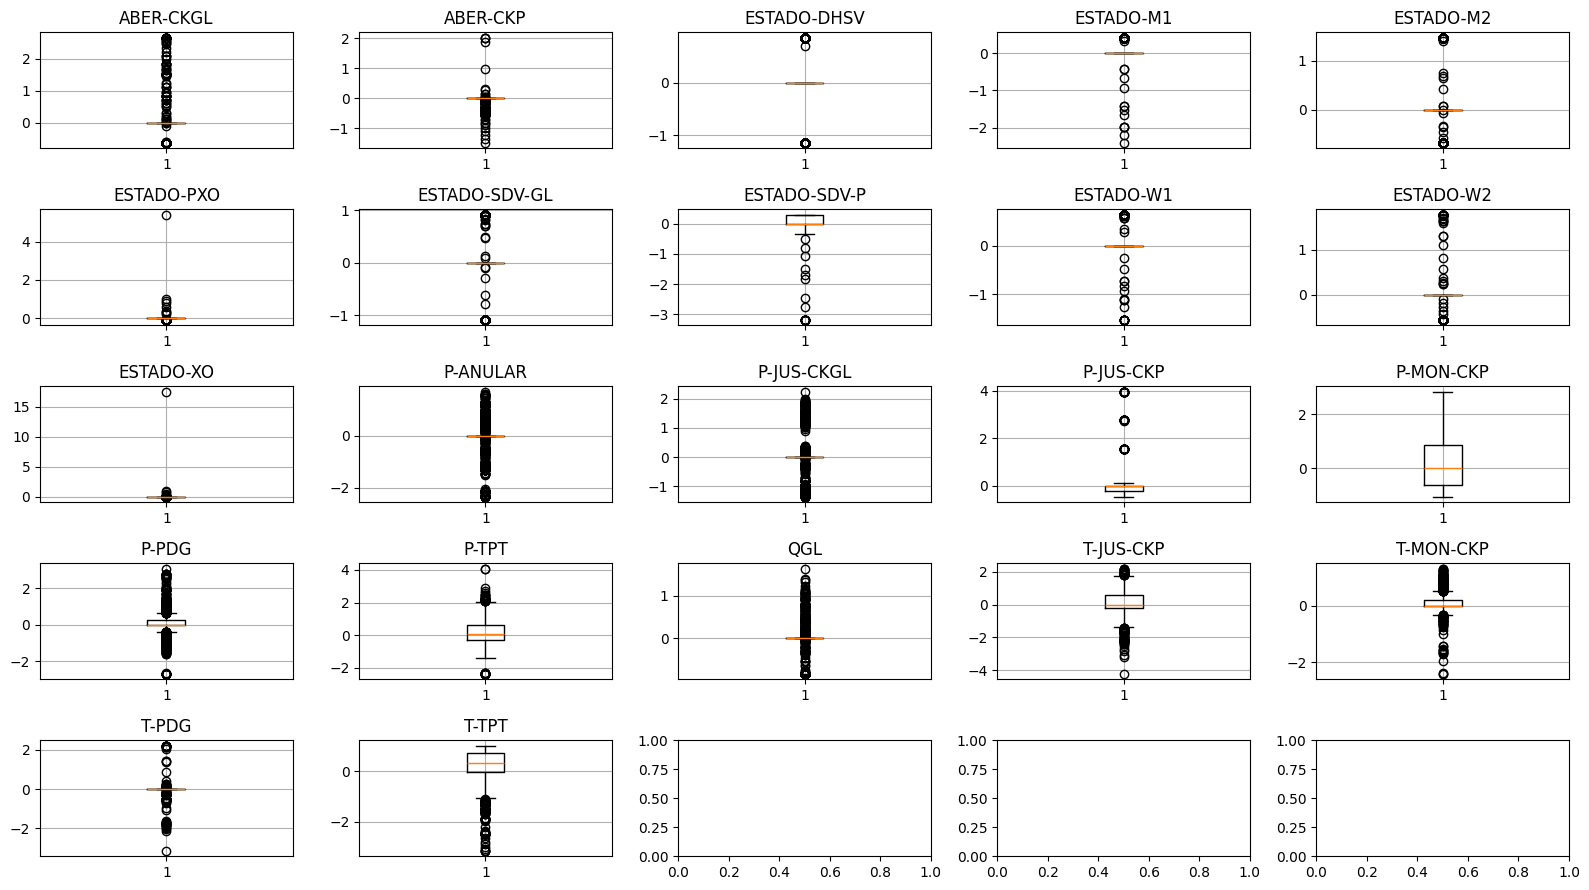

In [24]:
plot_boxes(distribution)